<a href="https://colab.research.google.com/github/jnsbrdbr/thesis/blob/thesis/part4_Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-rc0

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.7.0


In [2]:
import keras
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install --upgrade tables

In [5]:
with pd.HDFStore('/content/drive/MyDrive/1000/part2_result',  mode='r') as newstore:
    result = newstore.select('result')

In [6]:
#final data
print(result)

             0         1         2  ...         8         9  label
0    -1.680599 -3.061217 -0.040984  ... -0.006112 -0.004759      1
1    -1.680599 -3.061217 -0.040984  ... -0.006112 -0.004759      1
2    -1.680599 -3.061217 -0.040984  ... -0.006112 -0.004759      1
3    -1.680599 -3.061217 -0.040984  ... -0.006112 -0.004759      1
4    -1.680599 -3.061217 -0.040984  ...  0.006186  0.002988      1
...        ...       ...       ...  ...       ...       ...    ...
1315 -1.680599 -3.061217 -0.040984  ... -0.035323 -0.015205      0
1316 -1.680599 -3.061217 -0.040984  ... -0.012077 -0.016767      0
1317 -1.680599 -3.061217 -0.040984  ... -0.011761 -0.013474      0
1318 -1.680599 -3.061217 -0.040984  ...  0.004503  0.113459      0
1319 -1.680599 -3.061217 -0.040984  ... -0.022880  0.001418      0

[1320 rows x 71 columns]


In [7]:
#divide data in to data_label and non_data label

import copy
result_nonlabel=copy.deepcopy(result)
del result_nonlabel['label']
X=result_nonlabel
y=result.label

In [8]:
#splitting data in to test and train...

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y ,random_state=42,test_size=0.3)#

In [9]:
print('shape of x_train is:',X_train.shape)
print('shape of x_test is:',X_test.shape)

shape of x_train is: (924, 70)
shape of x_test is: (396, 70)


In [10]:
max(X_train.max())

7454.516836076623

In [11]:
min(X_train.min())

-127.3838709715454

In [12]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

In [13]:
make_latent_samples(1, 300) # generates one sample

array([[ 2.83323090e-02,  6.40594152e-02, -4.89627669e-01,
         1.17652996e-01, -3.09044429e+00, -2.56695978e-01,
        -1.08377439e+00, -4.23071056e-01, -2.69238897e+00,
        -7.88530497e-01,  9.49246892e-01, -4.94207081e-01,
        -5.29422805e-01, -9.85076597e-01, -9.61462403e-01,
        -1.54636451e+00,  8.67352231e-01,  1.06003858e-01,
         1.71583374e+00,  1.09431601e+00, -1.21409905e+00,
         2.37835267e-01, -1.12247334e+00,  2.23645539e+00,
         1.20772317e+00,  6.57986164e-01, -3.27792528e-01,
         1.00329842e+00, -2.68408955e-01, -1.61544883e+00,
        -1.31072237e-01, -1.02866881e+00,  1.41582424e+00,
        -5.88449599e-01,  3.05724960e-01, -1.45112382e+00,
        -1.68864529e+00,  1.09318964e-01, -9.00303197e-01,
         7.97242219e-01,  4.49092952e-01,  1.38322330e+00,
        -8.67813103e-01,  3.87021265e-01,  1.09198166e+00,
        -1.71650887e-02, -7.54562234e-01, -5.83666049e-01,
         4.93942732e-01, -5.02874998e-01,  4.73816531e-0

In [14]:
generator = Sequential([
    Dense(256, input_shape=(300,)),
    LeakyReLU(alpha=0.02),
    BatchNormalization(momentum=0.6),
    Dense(512),
    LeakyReLU(alpha=0.02),
    BatchNormalization(momentum=0.6),
    #Dense(1024),
    #LeakyReLU(alpha=0.02),
    #BatchNormalization(momentum=0.5),
    Dense(70),
    Activation('tanh')
], name='generator')

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               77056     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                         

In [15]:
discriminator = Sequential([
    Dense(128, input_shape=(70,)),
    LeakyReLU(alpha=0.02),
    BatchNormalization(momentum=0.6),
    Dense(64),
    LeakyReLU(alpha=0.02),
    BatchNormalization(momentum=0.6),
    Dense(32),
    LeakyReLU(alpha=0.02),
    Dense(16),
    LeakyReLU(alpha=0.02),
    BatchNormalization(momentum=0.6),
    Dense(1),
    Activation('sigmoid')
], name='discriminator')

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               9088      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64)                0         
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                     

In [16]:
# maintain the same shared weights with the generator and the discriminator.
gan = Sequential([
    generator,
    discriminator
])

gan.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Sequential)      (None, 70)                247622    
                                                                 
 discriminator (Sequential)  (None, 1)                 20801     
                                                                 
Total params: 268,423
Trainable params: 266,471
Non-trainable params: 1,952
_________________________________________________________________


In [17]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [18]:
make_trainable(discriminator, False)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               9088      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64)                0         
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                     

In [19]:
make_trainable(discriminator, True)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               9088      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64)                0         
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                     

In [20]:
def make_simple_GAN(sample_size, 
                    g_hidden_size_1,
                    g_hidden_size_2,
                    g_hidden_size_3,
                    d_hidden_size_1,
                    d_hidden_size_2, 
                    d_hidden_size_3,
                    d_hidden_size_4,
                    leaky_alpha, 
                    g_learning_rate,
                    d_learning_rate):
    K.clear_session()
    
    generator = Sequential([
        Dense(g_hidden_size_1, input_shape=(sample_size,)),
        LeakyReLU(alpha=leaky_alpha),
        BatchNormalization(momentum=0.6),
        Dense(g_hidden_size_2),
        LeakyReLU(alpha=leaky_alpha),
        BatchNormalization(momentum=0.6),
        #Dense(g_hidden_size_3),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.5),
        Dense(70),        
        Activation('tanh')
    ], name='generator')    

    discriminator = Sequential([
        Dense(d_hidden_size_1, input_shape=(70,)),
        LeakyReLU(alpha=leaky_alpha),
        BatchNormalization(momentum=0.6),
        Dense(d_hidden_size_2),
        LeakyReLU(alpha=leaky_alpha),
        BatchNormalization(momentum=0.6),
        Dense(d_hidden_size_3),
        LeakyReLU(alpha=leaky_alpha),
        #Dense(d_hidden_size_4),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.5),
        Dense(1),
        Activation('sigmoid')
    ], name='discriminator')    
    
    gan = Sequential([
        generator,
        discriminator
    ])
    
    discriminator.compile(optimizer=Adam(lr=d_learning_rate), loss='binary_crossentropy')
    gan.compile(optimizer=Adam(lr=g_learning_rate), loss='binary_crossentropy')
    
    return gan, generator, discriminator 

In [21]:
from sklearn import preprocessing
def preprocess(x):
   x = preprocessing.scale(x)
   return x

In [22]:
X_train_real = np.array(preprocess(X_train))
X_test_real  = np.array(preprocess(X_test))

In [23]:
while(False):

  def deprocess(x):
    x = (x / 2 + 1) * 7454.516836076623
    x = np.clip(x, -127.3838709715454, 7454.516836076623)
    x = np.uint8(x)
    x = x.reshape(-1, 70)
    return x

In [24]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

In [25]:
y_real_10, y_fake_10 = make_labels(10)

y_real_10, y_fake_10

(array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]), array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]))

In [26]:
# hyperparameters
sample_size     = 100     # latent sample size (i.e., 100 random numbers)
g_hidden_size_1 = 256
g_hidden_size_2 = 128
g_hidden_size_3 = 128
d_hidden_size_1 = 128
d_hidden_size_2 = 64
d_hidden_size_3 = 32
d_hidden_size_4 = 16
leaky_alpha     = 0.02
g_learning_rate = 0.0001  # learning rate for the generator
d_learning_rate = 0.001   # learning rate for the discriminator
epochs          = 150
batch_size      = 64      # train batch size
eval_size       = 16      # evaluate size
smooth          = 0.1


In [27]:
# labels for the batch size and the test size
y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

# create a GAN, a generator and a discriminator
gan, generator, discriminator = make_simple_GAN(
    sample_size, 
    g_hidden_size_1, 
    g_hidden_size_2,
    g_hidden_size_3, 
    d_hidden_size_1, 
    d_hidden_size_2,
    d_hidden_size_3,
    d_hidden_size_4,
    leaky_alpha, 
    g_learning_rate,
    d_learning_rate)


losses = []
losses1 = []
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real MNIST digit images
        X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
        
        # latent samples and the generated digit images
        latent_samples = make_latent_samples(batch_size, sample_size)
        X_batch_fake = generator.predict_on_batch(latent_samples)
        
        # train the discriminator to detect real and fake images
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)

        # train the generator via GAN
        make_trainable(discriminator, False)
        gan.train_on_batch(latent_samples, y_train_real)
   # evaluate
    X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]
    
    latent_samples = make_latent_samples(eval_size, sample_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)

    d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
    d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
    g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!
    
    losses.append((d_loss, g_loss))

    #d_acc_real = discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
    #d_acc_fake = discriminator.train_on_batch(X_batch_fake, y_train_fake)
    #d_acc  = 0.5 * (d_acc_real + d_acc_fake)

    #losses1.append(( d_acc))
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f} ".format(
        e+1, epochs, d_loss, g_loss)) #Discriminator acc: {:>6.4f}:,d_acc

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch:   1/150 Discriminator Loss: 0.8490 Generator Loss: 0.8833 
Epoch:   2/150 Discriminator Loss: 0.5759 Generator Loss: 1.3440 
Epoch:   3/150 Discriminator Loss: 0.3826 Generator Loss: 1.9041 
Epoch:   4/150 Discriminator Loss: 0.3120 Generator Loss: 2.0856 
Epoch:   5/150 Discriminator Loss: 0.3638 Generator Loss: 1.9797 
Epoch:   6/150 Discriminator Loss: 0.2489 Generator Loss: 2.3387 
Epoch:   7/150 Discriminator Loss: 0.2555 Generator Loss: 2.7112 
Epoch:   8/150 Discriminator Loss: 0.2231 Generator Loss: 3.0075 
Epoch:   9/150 Discriminator Loss: 0.1827 Generator Loss: 3.6129 
Epoch:  10/150 Discriminator Loss: 0.2631 Generator Loss: 2.8360 
Epoch:  11/150 Discriminator Loss: 0.1907 Generator Loss: 3.5854 
Epoch:  12/150 Discriminator Loss: 0.2415 Generator Loss: 3.3575 
Epoch:  13/150 Discriminator Loss: 0.2900 Generator Loss: 3.4735 
Epoch:  14/150 Discriminator Loss: 0.2202 Generator Loss: 3.6872 
Epoch:  15/150 Discriminator Loss: 0.4196 Generator Loss: 3.9020 
Epoch:  16

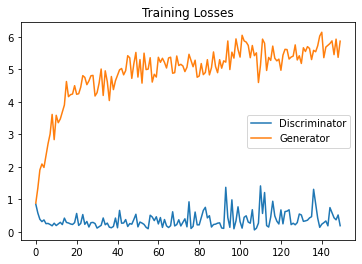

In [28]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

In [29]:
latent_samples = make_latent_samples(20, sample_size)
generated_digits = generator.predict(latent_samples)

In [30]:
for i in range(20):
    node = (generated_digits[i])
print(node)

[ 2.2859676e-01  9.6837497e-01  9.9353361e-01 -7.8791475e-01
 -1.6139989e-01  6.3954151e-01 -3.4938443e-01  6.7131066e-01
  3.2548830e-01  8.0756432e-01 -3.7294304e-01  5.1181924e-01
 -6.5027267e-01 -9.2418259e-01  9.3145853e-01 -8.1197745e-01
  4.7246203e-01 -5.2332026e-01 -8.6483735e-01 -7.3594767e-01
  5.2478808e-01 -4.8486069e-01 -8.6185050e-01  9.3853277e-01
  9.1418618e-01  2.6118804e-03  1.2194233e-01 -9.0105432e-01
 -8.2420862e-01 -3.9008230e-01  9.4920957e-01 -9.4305551e-01
 -8.1393814e-01 -6.2489051e-01  7.1482748e-01 -2.0557549e-04
  6.0110706e-01  3.9240342e-01 -1.5321022e-01  8.7354547e-01
 -9.9742228e-01 -2.0704091e-01  7.3491734e-01 -7.5474685e-01
  3.1813288e-01 -6.5644550e-01  9.2221951e-01 -9.0679657e-01
  1.5986374e-01  8.1081606e-02  8.9661747e-01  6.2286186e-01
 -4.2313206e-01 -1.3614374e-01  7.6287931e-01 -9.9520552e-01
  5.5665129e-01  5.1715273e-01 -7.1265680e-01 -2.4621573e-01
 -8.7953979e-01 -9.5738977e-01 -9.3004948e-01  2.2822453e-01
  9.3683630e-01  5.72794

In [31]:
rr = discriminator.predict_on_batch(X_test)

In [32]:
rr

array([[1.1950353e-06],
       [1.1950444e-06],
       [5.2038056e-01],
       [6.6079891e-01],
       [3.8493895e-06],
       [8.7121129e-04],
       [8.7121129e-04],
       [3.3427383e-05],
       [9.9631846e-01],
       [8.7121129e-04],
       [9.9631846e-01],
       [9.9631846e-01],
       [8.7121129e-04],
       [3.7521124e-04],
       [9.9998659e-01],
       [1.1950353e-06],
       [1.1950353e-06],
       [1.1950444e-06],
       [9.9998903e-01],
       [1.0772544e-01],
       [3.3427383e-05],
       [1.1950353e-06],
       [1.0000000e+00],
       [9.9876446e-01],
       [3.9421052e-02],
       [1.1950353e-06],
       [1.1950353e-06],
       [1.0000000e+00],
       [9.9631846e-01],
       [3.7521124e-04],
       [5.7443976e-04],
       [5.2038056e-01],
       [1.1950353e-06],
       [3.7521124e-04],
       [9.9631846e-01],
       [1.0772544e-01],
       [9.9631846e-01],
       [9.4570625e-01],
       [8.7121129e-04],
       [8.7121129e-04],
       [1.3570786e-03],
       [9.492933

In [33]:
rr.min()

2.1374862e-07

In [34]:
rr.max()

1.0

In [35]:
y_test

678     1
693     1
610     1
49      1
1291    0
       ..
141     1
820     1
613     1
543     1
139     1
Name: label, Length: 396, dtype: int64

In [36]:
import keras
#import keras_metrics

r = tf.keras.metrics.Recall(thresholds=rr.min())
r.update_state(y_test,rr )
r.result().numpy()


1.0

In [37]:
p=tf.keras.metrics.Precision(thresholds=rr.min())
p.update_state(y_test,rr )
p.result().numpy()

0.75949365